In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


In [4]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score = {:.3f}".format(roc_auc_score(Y_test, model.predict_proba(test)[:, 1])))

ROC AUC Score = 0.849


In [5]:
from sklearn.metrics import confusion_matrix

pred_test = model.predict_proba(test)
pred_test = np.argmax(pred_test, axis=1)

tn, fp, fn, tp = confusion_matrix(Y_test, pred_test, labels=[0,1]).ravel()
p = tp + fn
fnr = fn / p if p > 0.0 else np.float64(0.0)

print("False negative rate = {:.3f}".format(fnr))

False negative rate = 0.042


In [6]:
print("Classifier got {} positive examples wrong".format(int(round(Y_test.sum() * fnr))))

Classifier got 3 positive examples wrong


# Global FNR

In [7]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fnr = sage.PermutationEstimator(imputer, 'fnr')
%time sage_values_fnr = estimator_fnr(test, Y_test, verbose=True, thresh=0.2)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 356, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 356, fnr = 0.0028089887640449437
	Loss = 0.0028089887640449437 [inner loop]
fn = 2, p = 356, fnr = 0.0056179775280898875
	Loss = 0.0056179775280898875 [inner loop]
fn = 3, p = 356, fnr = 0.008426966292134831
	Loss = 0.008426966292134831 [inner loop]
fn = 4, p = 356, fnr = 0.011235955056179775
	Loss = 0.011235955056179775 [inner loop]
fn = 6, p = 356, fnr = 0.016853932584269662
	Loss = 0.016853932584269662 [inner loop]
fn = 6, p = 356, fnr = 0.016853932584269662
	Loss = 0.016853932584269662 [inner loop]
fn = 6, p = 356, fnr = 0.016853932584269662
	Loss = 0.016853932584269662 [inner loop]
fn = 8, p = 356, fnr = 0.02247191011235955
	Loss = 0.02247191011235955 [inner loop]
fn = 8, p = 356, fnr = 0.02247191011235955
	Loss = 0.02247191011235955 [inner loop]
fn = 9, p = 356, fnr = 0.025280898876404494
	Los

fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 10, p = 359, fnr = 0.027855153203342618
	Loss = 0.027855153203342618 [inner loop]
fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 12, p = 359, fnr = 0.033426183844011144
	Loss = 0.033426183844011144 [inner loop]
StdDev Ratio = 0.2977 (Converge at 0.2000)
fn = 0, p = 351, fnr = 0.0
===> Iteration 5, Prev loss = 0.0 [outer loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.0

fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 12, p = 364, fnr = 0.03296703296703297
	Loss = 0.03296703296703297 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 15, p = 364, fnr = 0.04120879120879121
	Loss = 0.04120879120879121 [inner loop]
fn = 13, p = 364, fnr = 0.03571428571428571
	Loss = 0.03571428571428571 [inner loop]
StdDev Ratio = 0.2915 (Converge at 0.2000)
fn = 0, p = 354, fnr = 0.0
===> Iteration 10, Prev loss = 0.0 [outer loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 354, fnr = 0.005649717514124294
	Loss = 0.005649

fn = 13, p = 372, fnr = 0.03494623655913978
	Loss = 0.03494623655913978 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 19, p = 372, fnr = 0.051075268817204304
	Loss = 0.051075268817204304 [inner loop]
fn = 18, p = 372, fnr = 0.04838709677419355
	Loss = 0.04838709677419355 [inner loop]
fn = 19, p = 372, fnr = 0.051075268817204304
	Loss = 0.051075268817204304 [inner loop]
fn = 21, p = 372, fnr = 0.056451612903225805
	Loss = 0.056451612903225805 [inner loop]
fn = 23, p = 372, fnr = 0.06182795698924731
	Loss = 0.06182795698924731 [inner loop]
fn = 21, p = 372, fnr = 0.056451612903225805
	Loss = 0.056451612903225805 [inner loop]
fn = 21, p = 372, fnr = 0.056451612903225805
	Loss = 0.056451612903225805 [inner loop]
StdDev Ratio = 0.3642 (Converge at 0.2000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 15, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
f

fn = 4, p = 350, fnr = 0.011428571428571429
	Loss = 0.011428571428571429 [inner loop]
fn = 4, p = 350, fnr = 0.011428571428571429
	Loss = 0.011428571428571429 [inner loop]
fn = 8, p = 350, fnr = 0.022857142857142857
	Loss = 0.022857142857142857 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 13, p = 350, fnr = 0.037142857142857144
	Loss = 0.037142857142857144 [inner loop]
fn = 13, p = 350, fnr = 0.037142857142857144
	Loss = 0.037142857142857144 [inner loop]
fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
StdDev Ratio = 0.3333 (Converge at 0.2000)
fn = 0, p = 357

fn = 3, p = 380, fnr = 0.007894736842105263
	Loss = 0.007894736842105263 [inner loop]
fn = 2, p = 380, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 5, p = 380, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 4, p = 380, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 6, p = 380, fnr = 0.015789473684210527
	Loss = 0.015789473684210527 [inner loop]
fn = 8, p = 380, fnr = 0.021052631578947368
	Loss = 0.021052631578947368 [inner loop]
fn = 10, p = 380, fnr = 0.02631578947368421
	Loss = 0.02631578947368421 [inner loop]
fn = 11, p = 380, fnr = 0.02894736842105263
	Loss = 0.02894736842105263 [inner loop]
fn = 11, p = 380, fnr = 0.02894736842105263
	Loss = 0.02894736842105263 [inner loop]
fn = 13, p = 380, fnr = 0.034210526315789476
	Loss = 0.034210526315789476 [inner loop]
fn = 12, p = 380, fnr = 0.031578947368421054
	Loss = 0.031578947368421054 [inner loop]
fn = 12, p = 380, fnr = 0.031578947368421054
	Loss = 0.

fn = 2, p = 376, fnr = 0.005319148936170213
	Loss = 0.005319148936170213 [inner loop]
fn = 2, p = 376, fnr = 0.005319148936170213
	Loss = 0.005319148936170213 [inner loop]
fn = 2, p = 376, fnr = 0.005319148936170213
	Loss = 0.005319148936170213 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340425532
	Loss = 0.013297872340425532 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340425532
	Loss = 0.013297872340425532 [inner loop]
fn = 8, p = 376, fnr = 0.02127659574468085
	Loss = 0.02127659574468085 [inner loop]
fn = 8, p = 376, fnr = 0.02127659574468085
	Loss = 0.02127659574468085 [inner loop]
fn = 11, p = 376, fnr = 0.02925531914893617
	Loss = 0.

fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
StdDev Ratio = 0.2988 (Converge at 0.2000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 34, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.008310249307479225 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.011

fn = 7, p = 363, fnr = 0.01928374655647383
	Loss = 0.01928374655647383 [inner loop]
fn = 9, p = 363, fnr = 0.024793388429752067
	Loss = 0.024793388429752067 [inner loop]
fn = 8, p = 363, fnr = 0.02203856749311295
	Loss = 0.02203856749311295 [inner loop]
fn = 10, p = 363, fnr = 0.027548209366391185
	Loss = 0.027548209366391185 [inner loop]
fn = 11, p = 363, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 13, p = 363, fnr = 0.03581267217630854
	Loss = 0.03581267217630854 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
StdDev Ratio = 0.3229 (Converge at 0.2000)
fn = 0, p = 366, fnr = 0.0
===> Iteration 39, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 2, p = 366, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 3, p = 

fn = 7, p = 350, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 9, p = 350, fnr = 0.025714285714285714
	Loss = 0.025714285714285714 [inner loop]
fn = 11, p = 350, fnr = 0.03142857142857143
	Loss = 0.03142857142857143 [inner loop]
fn = 16, p = 350, fnr = 0.045714285714285714
	Loss = 0.045714285714285714 [inner loop]
fn = 14, p = 350, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 14, p = 350, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 17, p = 350, fnr = 0.04857142857142857
	Loss = 0.04857142857142857 [inner loop]
fn = 14, p = 350, fnr = 0.04
	Loss = 0.04 [inner loop]
StdDev Ratio = 0.2535 (Converge at 0.2000)
fn = 0, p = 367, fnr = 0.0
===> Iteration 44, Prev loss = 0.0 [outer loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	

fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 4, p = 377, fnr = 0.010610079575596816
	Loss = 0.010610079575596816 [inner loop]
fn = 4, p = 377, fnr = 0.010610079575596816
	Loss = 0.010610079575596816 [inner loop]
fn = 5, p = 377, fnr = 0.013262599469496022
	Loss = 0.013262599469496022 [inner loop]
fn = 9, p = 377, fnr = 0.023872679045092837
	Loss = 0.023872679045092837 [inner loop]
fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.026525198938992044 [inner loop]
fn = 12, p = 377, fnr = 0.03183023872679045
	Loss = 0.03183023872679045 [inner loop]
fn = 12, p = 377, fnr = 0.03183023872679045
	Loss = 0.03183023872679045 [inner loop]
fn = 13, p = 377, fnr = 0.034482758620689655
	Loss = 0.

fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 5, p = 362, fnr = 0.013812154696132596
	Loss = 0.013812154696132596 [inner loop]
fn = 6, p = 362, fnr = 0.016574585635359115
	Loss = 0.016574585635359115 [inner loop]
fn = 6, p = 362, fnr = 0.016574585635359115
	Loss = 0.016574585635359115 [inner loop]
fn = 7, p = 362, fnr = 0.019337016574585635
	Loss = 0.0193370165

fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
fn = 14, p = 366, fnr = 0.03825136612021858
	Loss = 0.03825136612021858 [inner loop]
StdDev Ratio = 0.2911 (Converge at 0.2000)
fn = 0, p = 347, fnr = 0.0
===> Iteration 58, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 3, p = 347, fnr = 0.008645533141210375
	Loss = 0.008645533141210375 [inner loop]
fn = 5, p = 347, fnr = 0.01440922190201729
	Loss = 0.01440922190201729 [inner loop]
fn = 5, p = 347, fnr = 0.01440922190201729
	Loss = 0.01440922190201729 [inner loop]
fn = 7, p = 347, fnr = 0.020172910662824207
	Loss = 0.020172910662824207 [inner loop]
fn = 9, p = 347, fnr = 0.025936599423631124
	Loss = 0.025936599423631124 [inner loop]
fn = 9, p = 347, fnr = 0.025936599423631124
	Loss = 0.025936

fn = 8, p = 376, fnr = 0.02127659574468085
	Loss = 0.02127659574468085 [inner loop]
fn = 9, p = 376, fnr = 0.023936170212765957
	Loss = 0.023936170212765957 [inner loop]
fn = 13, p = 376, fnr = 0.034574468085106384
	Loss = 0.034574468085106384 [inner loop]
fn = 14, p = 376, fnr = 0.03723404255319149
	Loss = 0.03723404255319149 [inner loop]
fn = 15, p = 376, fnr = 0.0398936170212766
	Loss = 0.0398936170212766 [inner loop]
fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 15, p = 376, fnr = 0.0398936170212766
	Loss = 0.0398936170212766 [inner loop]
StdDev Ratio = 0.2738 (Converge at 0.2000)
fn = 0, p = 383, fnr = 0.0
===> Iteration 63, Prev loss = 0.0 [outer loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 0, p = 383,

fn = 6, p = 368, fnr = 0.016304347826086956
	Loss = 0.016304347826086956 [inner loop]
fn = 6, p = 368, fnr = 0.016304347826086956
	Loss = 0.016304347826086956 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 6, p = 368, fnr = 0.016304347826086956
	Loss = 0.016304347826086956 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 9, p = 368, fnr = 0.024456521739130436
	Loss = 0.024456521739130436 [inner loop]
fn = 9, p = 368, fnr = 0.024456521739130436
	Loss = 0.024456521739130436 [inner loop]
fn = 11, p = 368, fnr = 0.029891304347826088
	Loss = 0.029891304347826088 [inner loop]
fn = 10, p = 368, fnr = 0.02717391304347826
	Loss = 0.02717391304347826 [inner loop]
fn = 9, p = 368, fnr = 0.024456521739130436
	Loss = 0.024456521739130436 [inner loop]
StdDev Ratio = 0.2661 (Converge at 0.2000)
fn = 0, p = 362, 

fn = 2, p = 379, fnr = 0.005277044854881266
	Loss = 0.005277044854881266 [inner loop]
fn = 4, p = 379, fnr = 0.010554089709762533
	Loss = 0.010554089709762533 [inner loop]
fn = 4, p = 379, fnr = 0.010554089709762533
	Loss = 0.010554089709762533 [inner loop]
fn = 6, p = 379, fnr = 0.0158311345646438
	Loss = 0.0158311345646438 [inner loop]
fn = 9, p = 379, fnr = 0.023746701846965697
	Loss = 0.023746701846965697 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 7, p = 379, fnr = 0.018469656992084433
	Loss = 0.018469656992084433 [inner loop]
fn = 9, p = 379, fnr = 0.023746701846965697
	Loss = 0.023746701846965697 [inner loop]
fn = 11, p = 379, fnr = 0.029023746701846966
	Loss = 0.029023746701846966 [inner loop]
fn = 16, p = 379, fnr = 0.04221635883905013
	Loss = 0.04221635883905013 [inner loop]
fn = 22, p = 379, fnr = 0.05804749340369393
	Loss = 0.05804749340369393 [inner loop]
fn = 24, p = 379, fnr = 0.0633245382585752
	Loss = 0.063324

fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 5, p = 360, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 9, p = 360, f

fn = 11, p = 370, fnr = 0.02972972972972973
	Loss = 0.02972972972972973 [inner loop]
StdDev Ratio = 0.2272 (Converge at 0.2000)
fn = 0, p = 357, fnr = 0.0
===> Iteration 82, Prev loss = 0.0 [outer loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 3, p = 357, fnr = 0.008403361344537815
	Loss = 0.008403361344537815 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 3, p = 357, fnr = 0.008403361344537815
	Loss = 0.008403361344537815 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 8, p = 357, fnr = 0.022408963585434174
	Loss = 0.022408963585434174 [inner loop]
fn = 13, p = 357, fnr = 0.036414565

fn = 14, p = 349, fnr = 0.04011461318051576
	Loss = 0.04011461318051576 [inner loop]
fn = 15, p = 349, fnr = 0.04297994269340974
	Loss = 0.04297994269340974 [inner loop]
fn = 18, p = 349, fnr = 0.05157593123209169
	Loss = 0.05157593123209169 [inner loop]
fn = 17, p = 349, fnr = 0.04871060171919771
	Loss = 0.04871060171919771 [inner loop]
fn = 21, p = 349, fnr = 0.06017191977077364
	Loss = 0.06017191977077364 [inner loop]
fn = 22, p = 349, fnr = 0.06303724928366762
	Loss = 0.06303724928366762 [inner loop]
fn = 23, p = 349, fnr = 0.0659025787965616
	Loss = 0.0659025787965616 [inner loop]
fn = 20, p = 349, fnr = 0.05730659025787966
	Loss = 0.05730659025787966 [inner loop]
StdDev Ratio = 0.2419 (Converge at 0.2000)
fn = 0, p = 383, fnr = 0.0
===> Iteration 87, Prev loss = 0.0 [outer loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner lo

fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 4, p = 377, fnr = 0.010610079575596816
	Loss = 0.010610079575596816 [inner loop]
fn = 5, p = 377, fnr = 0.013262599469496022
	Loss = 0.013262599469496022 [inner loop]
fn = 7, p = 377, fnr = 0.01856763925729443
	Loss = 0.01856763925729443 [inner loop]
fn = 7, p = 377, fnr = 0.01856763925729443
	Loss = 0.01856763925729443 [inner loop]
fn = 8, p = 377, fnr = 0.021220159151193633
	Loss = 0.021220159151193633 [inner loop]
fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.026525198938992044 [inner loop]
fn = 8, p = 377, fnr = 0.021220159151193633
	Loss = 0.021220159151193633 [inner loop]
fn = 9, p = 377, fnr = 0.023872679045092837
	Loss = 0.023872679045092837 [inner loop]
fn = 12, p = 377, fnr = 0.03183023872679045
	Loss = 0.031

fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 3, p = 367, fnr = 0.008174386920980926
	Loss = 0.008174386920980926 [inner loop]
fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]
fn = 7, p = 367, fnr = 0.01907356948228883
	Loss = 0.01907356948228883 [inner loop]
fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
fn = 16, p = 367, fnr = 0.04359673024523160

fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 7, p = 361, fnr = 0.019390581717451522
	Loss = 0.019390581717451522 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 7, p = 361, fnr = 0.019390581717451522
	Loss = 0.019390581717451522 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922

fn = 15, p = 365, fnr = 0.0410958904109589
	Loss = 0.0410958904109589 [inner loop]
fn = 15, p = 365, fnr = 0.0410958904109589
	Loss = 0.0410958904109589 [inner loop]
fn = 11, p = 365, fnr = 0.030136986301369864
	Loss = 0.030136986301369864 [inner loop]
fn = 14, p = 365, fnr = 0.038356164383561646
	Loss = 0.038356164383561646 [inner loop]
StdDev Ratio = 0.2358 (Converge at 0.2000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 106, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 355, fnr = 0.0028169014084507044
	Loss = 0.0028169014084507044 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.008450704225352112 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 5, p = 355, fnr = 0.01408450704225

fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 20, p = 372, fnr = 0.053763440860215055
	Loss = 0.053763440860215055 [inner loop]
fn = 21, p = 372, fnr = 0.056451612903225805
	Loss = 0.056451612903225805 [inner loop]
fn = 22, p = 372, fnr = 0.05913978494623656
	Loss = 0.05913978494623656 [inner loop]
fn = 22, p = 372, fnr = 0.05913978494623656
	Loss = 0.05913978494623656 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
StdDev Ratio = 0.2419 (Converge at 0.2000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 111, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, f

fn = 11, p = 376, fnr = 0.02925531914893617
	Loss = 0.02925531914893617 [inner loop]
fn = 13, p = 376, fnr = 0.034574468085106384
	Loss = 0.034574468085106384 [inner loop]
fn = 14, p = 376, fnr = 0.03723404255319149
	Loss = 0.03723404255319149 [inner loop]
fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 18, p = 376, fnr = 0.047872340425531915
	Loss = 0.047872340425531915 [inner loop]
fn = 17, p = 376, fnr = 0.04521276595744681
	Loss = 0.04521276595744681 [inner loop]
fn = 19, p = 376, fnr = 0.05053191489361702
	Loss = 0.05053191489361702 [inner loop]
fn = 15, p = 376, fnr = 0.0398936170212766
	Loss = 0.0398936170212766 [inner loop]
StdDev Ratio = 0.2470 (Converge at 0.2000)
fn = 0, p = 354, fnr = 0.0
===> Iteration 116, Prev loss = 0.0 [outer loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858

fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 7, p = 363, fnr = 0.01928374655647383
	Loss = 0.01928374655647383 [inner loop]
fn = 10, p = 363, fnr = 0.027548209366391185
	Loss = 0.027548209366391185 [inner loop]
fn = 10, p = 363, fnr = 0.027548209366391185
	Loss = 0.027548209366391185 [inner loop]
fn = 13, p = 363, fnr = 0.03581267217630854
	Loss = 0.03581267217630854 [inner loop]
fn = 11, p = 363, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
fn = 15, p = 363, fnr = 0.04132231404958678
	Loss = 0.0

fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 388, fnr = 0.002577319587628866
	Loss = 0.002577319587628866 [inner loop]
fn = 2, p = 388, fnr = 0.005154639175257732
	Loss = 0.005154639175257732 [inner loop]
fn = 1, p = 388, fnr = 0.002577319587628866
	Loss = 0.002577319587628866 [inner loop]
fn = 2, p = 388, fnr = 0.005154639175257732
	Loss = 0.005154639175257732 [inner loop]
fn = 5, p = 388, fnr = 0.01288659793814433
	Loss = 0.01288659793814433 [inner loop]
fn = 5, p = 388, fnr = 0.01288659793814433
	Loss = 0.01288659793814433 [inner loop]
fn = 3, p = 388, fnr = 0.007731958762886598
	Loss = 0.007731958762886598 [inner loop]
fn = 4, p = 388, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 6, p = 388, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [inner loop]
fn = 6, p = 388, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [

fn = 11, p = 374, fnr = 0.029411764705882353
	Loss = 0.029411764705882353 [inner loop]
fn = 14, p = 374, fnr = 0.0374331550802139
	Loss = 0.0374331550802139 [inner loop]
fn = 19, p = 374, fnr = 0.05080213903743316
	Loss = 0.05080213903743316 [inner loop]
fn = 16, p = 374, fnr = 0.0427807486631016
	Loss = 0.0427807486631016 [inner loop]
fn = 14, p = 374, fnr = 0.0374331550802139
	Loss = 0.0374331550802139 [inner loop]
StdDev Ratio = 0.2169 (Converge at 0.2000)
fn = 0, p = 358, fnr = 0.0
===> Iteration 130, Prev loss = 0.0 [outer loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 358, fnr = 0.002793296089385475
	Loss = 0.002793296089385475 [inner loop]
fn = 1, p = 358, fnr = 0.002793296089385475
	Loss = 0.002793296089385475 [inner loop]
fn = 2, p = 358, fnr = 0.00558659217877095
	Loss = 0.00558659217877095 [inner lo

fn = 9, p = 368, fnr = 0.024456521739130436
	Loss = 0.024456521739130436 [inner loop]
fn = 10, p = 368, fnr = 0.02717391304347826
	Loss = 0.02717391304347826 [inner loop]
fn = 13, p = 368, fnr = 0.035326086956521736
	Loss = 0.035326086956521736 [inner loop]
fn = 13, p = 368, fnr = 0.035326086956521736
	Loss = 0.035326086956521736 [inner loop]
fn = 12, p = 368, fnr = 0.03260869565217391
	Loss = 0.03260869565217391 [inner loop]
fn = 14, p = 368, fnr = 0.03804347826086957
	Loss = 0.03804347826086957 [inner loop]
fn = 17, p = 368, fnr = 0.04619565217391304
	Loss = 0.04619565217391304 [inner loop]
fn = 17, p = 368, fnr = 0.04619565217391304
	Loss = 0.04619565217391304 [inner loop]
fn = 17, p = 368, fnr = 0.04619565217391304
	Loss = 0.04619565217391304 [inner loop]
StdDev Ratio = 0.2054 (Converge at 0.2000)
fn = 0, p = 359, fnr = 0.0
===> Iteration 135, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0,

fn = 3, p = 331, fnr = 0.00906344410876133
	Loss = 0.00906344410876133 [inner loop]
fn = 2, p = 331, fnr = 0.006042296072507553
	Loss = 0.006042296072507553 [inner loop]
fn = 1, p = 331, fnr = 0.0030211480362537764
	Loss = 0.0030211480362537764 [inner loop]
fn = 2, p = 331, fnr = 0.006042296072507553
	Loss = 0.006042296072507553 [inner loop]
fn = 4, p = 331, fnr = 0.012084592145015106
	Loss = 0.012084592145015106 [inner loop]
fn = 6, p = 331, fnr = 0.01812688821752266
	Loss = 0.01812688821752266 [inner loop]
fn = 8, p = 331, fnr = 0.02416918429003021
	Loss = 0.02416918429003021 [inner loop]
fn = 9, p = 331, fnr = 0.027190332326283987
	Loss = 0.027190332326283987 [inner loop]
fn = 11, p = 331, fnr = 0.03323262839879154
	Loss = 0.03323262839879154 [inner loop]
fn = 11, p = 331, fnr = 0.03323262839879154
	Loss = 0.03323262839879154 [inner loop]
fn = 14, p = 331, fnr = 0.04229607250755287
	Loss = 0.04229607250755287 [inner loop]
fn = 15, p = 331, fnr = 0.045317220543806644
	Loss = 0.045317

fn = 0, p = 383, fnr = 0.0
===> Iteration 144, Prev loss = 0.0 [outer loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 4, p = 383, fnr = 0.010443864229765013
	Loss = 0.010443864229765013 [inner loop]
fn = 4, p = 383, fnr = 0.010443864229765013
	Loss = 0.010443864229765013 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 5, p = 383, fnr = 0.013054830287206266
	Loss = 0.013054830287206266 [inner loop]
fn = 6, p = 383, fnr = 0.015665796344647518
	Loss = 0.015665796344647518 [inner loop]
fn = 6, p = 383, fnr = 0.015665796344647518
	L

fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 16, p = 350, fnr = 0.045714285714285714
	Loss = 0.045714285714285714 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
StdDev Ratio = 0.2203 (Converge at 0.2000)
fn = 0, p = 364, fnr = 0.0
===> Iteration 149, Prev loss = 0.0 [outer loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]

fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 9, p = 364, fnr = 0.024725274725274724
	Loss = 0.024725274725274724 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 13, p = 364, fnr = 0.03571428571428571
	Loss = 0.03571428571428571 [inner loop]
fn = 12, p = 364, fnr = 0.03296703296703297
	Loss = 0.03296703296703297 [inner loop]
fn = 16, p = 364, fnr = 0.04395604395604396
	Loss = 0.04395604395604396 [inner loop]
StdDev Ratio = 0.2184 (Converge at 0.2000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 154, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, 

fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 8, p = 363, fnr = 0.02203856749311295
	Loss = 0.02203856749311295 [inner loop]
fn = 8, p = 363, fnr = 0.02203856749311295
	Loss = 0.02203856749311295 [inner loop]
fn = 11, p = 363, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 16, p = 363, fnr = 0.0440771349862259
	Loss = 0.0440771349862259 [inner loop]
fn = 18, p = 363, fnr = 0.049586776859504134
	Loss = 0.049586776859504134 [inner loop]
fn = 16, p = 363, fnr = 0.0440771349862259
	Loss = 0.0440771349862259 [inner loop]
StdDev Ratio = 0.1945 (Converge at 0.2000)
Detected convergence


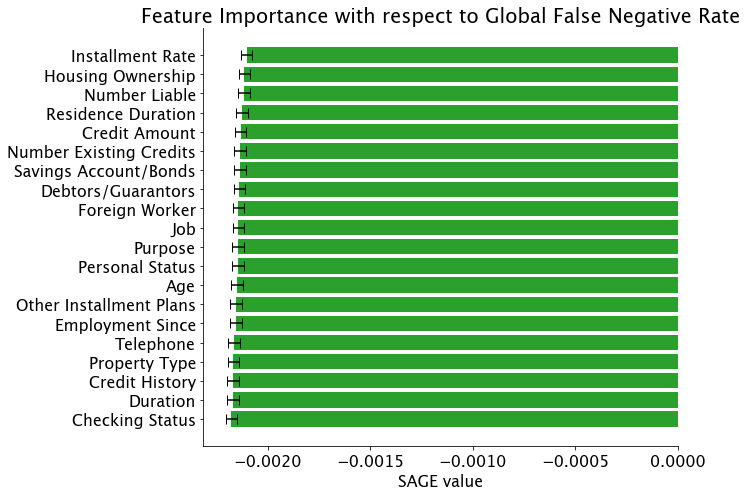

In [8]:
sage_values_fnr.plot(feature_names, title='Feature Importance with respect to Global False Negative Rate')

# Young group FNR

In [9]:
age_col = feature_names.index("Age")

In [10]:
where_young_train = train[:,age_col] <= 30
where_young_test = test[:,age_col] <= 30

test_young = test[where_young_test]
Y_test_young = Y_test[where_young_test]

In [12]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[where_young_train])
estimator_young_fnr = sage.PermutationEstimator(imputer_young, 'fnr')
%time sage_values_young_fnr = estimator_young_fnr(test_young, Y_test_young, verbose=True, thresh=0.2)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_young_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 304, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 6, p = 304, fnr = 0.019736842105263157
	Loss = 0.019736842105263157 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner lo

fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 5, p = 288, fnr = 0.017361111111111112
	Loss = 0.017361111111111112 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 5, p = 288, fnr = 0.017361111111111112
	Loss = 0.017361111111111112 [inner loop]
fn = 5, p = 288, fnr = 0.017361111111111112
	Loss = 0.017361111111111112 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.0138888888888888

fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 5, p = 293, fnr = 0.017064846416382253
	Loss = 

fn = 4, p = 282, fnr = 0.014184397163120567
	Loss = 0.014184397163120567 [inner loop]
fn = 3, p = 282, fnr = 0.010638297872340425
	Loss = 0.010638297872340425 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3207 (Converge at 0.2000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 16, Prev loss = 0.0 [outer loop]
fn = 0, p 

fn = 5, p = 280, fnr = 0.017857142857142856
	Loss = 0.017857142857142856 [inner loop]
fn = 4, p = 280, fnr = 0.014285714285714285
	Loss = 0.014285714285714285 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3151 (Converge at 0.2000)
fn = 0, p = 299, fnr = 0.0
===> Iteration 21, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss =

fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2764 (Converge at 0.2000)
fn = 0, p = 293, fnr = 0.0
===> Iteration 26, Prev loss = 0.0 [outer loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351


fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2567 (Converge at 0.2000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 31, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 4, p = 306, fnr

fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2928 (Converge at 0.2000)
fn = 0, p = 308, fnr = 0.0
===> Iteration 36, Prev loss = 0.0 [outer loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 4

fn = 0, p = 301, fnr = 0.0
===> Iteration 41, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.01328903654485049

fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2715 (Converge at 0.2000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 46, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.00

fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Los

fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 0, p = 

fn = 8, p = 298, fnr = 0.026845637583892617
	Loss = 0.026845637583892617 [inner loop]
fn = 8, p = 298, fnr = 0.026845637583892617
	Loss = 0.026845637583892617 [inner loop]
fn = 7, p = 298, fnr = 0.02348993288590604
	Loss = 0.02348993288590604 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2393 (Converge at 0.2000)
fn = 0, p = 312, fnr = 0.0
===> Iteration 62, Prev loss = 0.0 [outer loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [

fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2510 (Converge at 0.2000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 67, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p 

fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2707 (Converge at 0.2000)
fn = 0, p = 285, fnr = 0.0
===> Iteration 72, Prev loss = 0.0 [outer loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0

fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2895 (Converge at 0.2000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 77, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 4, p = 29

fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3243 (Converge at 0.2000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 82, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 8, p = 296, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 7, p = 296, fnr = 0.02364864864864865
	Loss = 0.023

fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 

fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301

fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3172 (Converge at 0.2000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 98, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0

fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3243 (Converge at 0.2000)
fn = 0, p = 307, fnr = 0.0
===> Iteration 103, Prev loss = 0.0 [outer loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner l

fn = 4, p = 295, fnr = 0.013559322033898305
	Loss = 0.013559322033898305 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3164 (Converge at 0.2000)
fn = 0, p = 316, fnr = 0.0
===> Iteration 108, Prev loss = 0.0 [outer loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.003164

fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3596 (Converge at 0.2000)
fn = 0, p = 284, fnr = 0.0
===> Iteration 113, Prev loss = 0.0 [outer loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.

fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3473 (Converge at 0.2000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 118, Prev loss = 0.0 [outer loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333

fn = 2, p = 283, fnr = 0.007067137809187279
	Loss = 0.007067137809187279 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3482 (Converge at 0.2000)
fn = 0, p = 299, fnr = 0.0
===> Iteration 123, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0

fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3358 (Converge at 0.2000)
fn = 0, p = 293, fnr = 0.0
===> Iteration 128, Prev loss = 0.0 [outer loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.01023

fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3518 (Converge at 0.2000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 133, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.00

fn = 0, p = 282, fnr = 0.0
===> Iteration 138, Prev loss = 0.0 [outer loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Lo

fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 3, p = 313, fnr = 0.009584664536741214
	Loss = 0.009584664536741214 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 3, p = 313, fnr = 0.009584664536741214
	Loss = 0.009584664536741214 [inner loop]
fn = 4, p = 313, fnr = 0.012779552715654952
	Loss = 0.012779552715654952 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 4, p = 313, fnr = 0.012779552715654952
	Loss = 0.012779552715654952 [inner loop]
fn

fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.00330

fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 2, p = 300, fnr = 0.00666666666

fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3140 (Converge at 0.2000)
fn = 0, p = 318, fnr = 0.0
===> Iteration 159, Prev loss = 0.0 [outer loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn 

fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2846 (Converge at 0.2000)
fn = 0, p = 286, 

fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2914 (Converge at 0.2000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 169, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.00671140939

fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2801 (Converge at 0.2000)
fn = 0, p = 289, fnr = 0.0
===> Iteration 174, Prev loss = 0.0 [outer loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 5, p = 289, fnr = 0.01730103806228374
	Loss = 0.01730103806228374 [inner loop]
fn = 6, p = 289, fnr = 0.020761245674740483
	Loss = 0.020761245674740483 [inner loop]
fn = 5, p = 289, fnr = 0.017301038062

fn = 0, p = 302, fnr = 0.0
===> Iteration 179, Prev loss = 0.0 [outer loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 6, p = 302, fnr = 0.019867549668874173
	Loss = 0.0198

fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2620 (Converge at 0.2000)
fn = 0, p = 290, fnr = 0.0
===> Iteration 184, Prev loss = 0.0 [outer loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.00

fn = 0, p = 329, fnr = 0.0
===> Iteration 189, Prev loss = 0.0 [outer loop]
fn = 0, p = 329, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 329, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 329, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 329, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 329, fnr = 0.00303951367781155
	Loss = 0.00303951367781155 [inner loop]
fn = 0, p = 329, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 329, fnr = 0.00303951367781155
	Loss = 0.00303951367781155 [inner loop]
fn = 3, p = 329, fnr = 0.00911854103343465
	Loss = 0.00911854103343465 [inner loop]
fn = 4, p = 329, fnr = 0.0121580547112462
	Loss = 0.0121580547112462 [inner loop]
fn = 3, p = 329, fnr = 0.00911854103343465
	Loss = 0.00911854103343465 [inner loop]
fn = 2, p = 329, fnr = 0.0060790273556231
	Loss = 0.0060790273556231 [inner loop]
fn = 4, p = 329, fnr = 0.0121580547112462
	Loss = 0.0121580547112462 [inner loop]
fn = 7, p = 329, fnr = 0.02127659574468085
	Loss = 0.02127659574468085 [inner loop

fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 6, p = 290, fnr = 0.0

fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 4, p = 315, fnr = 0.012698412698412698
	Loss = 0.012698412698412698 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 4, p = 315, fnr = 0.012698412698412698
	Loss = 0.012698412698412698 [inner loop]
fn = 4, p = 315, fnr = 0.012698412698412698
	Loss = 0.012698412698412698 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.

fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.

fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2846 (Converge at 0.2000)
fn = 0, p = 288, fnr = 0.0
===> Iteration 210, Prev loss = 0.0 [outer loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.

fn = 4, p = 281, fnr = 0.014234875444839857
	Loss = 0.014234875444839857 [inner loop]
fn = 4, p = 281, fnr = 0.014234875444839857
	Loss = 0.014234875444839857 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2696 (Converge at 0.2000)
fn = 0, p = 281, fnr = 0.0
===> Iteration 215, Prev loss = 0.0 [outer loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 1, p =

fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2839 (Converge at 0.2000)
fn = 0, p = 324, fnr = 0.0
===> Iteration 220, Prev loss = 0.0 [outer loop]
fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 324, fnr = 0.0030864197530864196
	Loss = 0.0030864197530864196 [inner loop]
fn = 1, p = 324, fnr = 0.0030864197530864196
	Loss = 0.0030864197530864196 [inner loop]
fn = 1, p = 324, fnr = 0.0030864197530864196
	Loss = 0.0030864197530864196 [inner loop]
fn = 2, p = 324, fnr = 0.006172839506172839
	Loss = 0.006172839506172839 [inner loop]
fn = 3, p = 324, fnr = 0.009259259259259259
	Loss = 0.009259259259259259 [inner

fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2566 (Converge at 0.2000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 225, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 303, fnr 

fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2479 (Converge at 0.2000)
fn = 0, p = 305, fnr = 0.0
===> Iteration 230, Prev loss = 0.0 [outer loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 3, p = 305, fnr = 0.0098360655

fn = 0, p = 288, fnr = 0.0
===> Iteration 235, Prev loss = 0.0 [outer loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 3, p 

fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 5, p = 301, fnr = 0.016611295681063124
	Loss = 0.016611295681063124 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	L

fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Los

fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 4, p = 284, fnr = 0.014084507042253521
	Loss = 0.014084507042253521 [inner loop]
fn = 4, p = 284, fnr = 0.014084507042253521
	Loss = 0.014084507042253521 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2159 (Converge at 0.2000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 256, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300

fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2364 (Converge at 0.2000)
fn = 0, p = 286, fnr = 0.0
===> Iteration 261, Prev loss = 0.0 [outer loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss

fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2260 (Converge at 0.2000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 266, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loo

fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2248 (Converge at 0.2000)
fn = 0, p = 313, fnr = 0.0
===> Iteration 271, Prev loss = 0.0 [outer loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 3, p = 313, fnr = 0.009584664536741214
	Loss = 0.009584664536741214 [inner loop]
fn = 4, p = 313, fnr = 0.012779552715654952
	Loss = 0.012779552715654952 [inner loop]
fn = 4, p = 313, fnr = 0.012779552715654952
	Loss = 0.012779552715654952 [inner loop]
f

fn = 0, p = 267, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 267, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 267, fnr = 0.003745318352059925
	Loss = 0.003745318352059925 [inner loop]
fn = 1, p = 267, fnr = 0.003745318352059925
	Loss = 0.003745318352059925 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 1, p = 267, fnr = 0.003745318352059925
	Loss = 0.003745318352059925 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss = 0.00749063670411985 [inner loop]
fn = 2, p = 267, fnr = 0.00749063670411985
	Loss =

fn = 0, p = 295, fnr = 0.0
===> Iteration 281, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728


fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 4, p = 278, fnr = 0.014388489208633094
	Loss = 0.014388489208633094 [inner loop]
fn = 7, p = 278, fnr = 0.025179856115107913
	Loss = 0.025179856115107913 [inner loop]
fn = 5, p = 278, fnr = 0.017985611510791366
	Loss = 0.017985611510791366 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, 

fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 5, p = 317, fnr = 0.015772870662460567
	Loss = 0.015772870662460567 [inner loop]
fn = 7, p = 317, fnr = 0.022082018927444796
	Loss = 0.022082018927444796 [inner loop]
fn = 7, p = 317, fnr = 0.022082018927444796
	Loss = 0.022082018927444796 [inner loop]
fn = 8, p = 317, fnr = 0.025236593059936908
	Loss = 0.025236593059936908 [inner loop]
fn = 6, p = 317, fnr = 0.01892744479495268
	Loss = 0.01892744479495268 [inner loop]
fn = 4, p = 317, fnr = 0.012618296529968454
	Loss = 0.012618296529968454 [inner loop]
fn = 5, p = 317, fnr = 0.015772870662460567
	Loss = 0.015772870662460567 [inner loop]
fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2370 (Converge at 0.2000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 292, Prev loss = 0.0 [outer loop]
fn = 0,

fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2495 (Converge at 0.2000)
fn = 0, p = 305, fnr = 0.0
===> Iteration 297, Prev loss = 0.0 [outer loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.

fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2465 (Converge at 0.2000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 302, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.00330033003300

fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2476 (Converge at 0.2000)
fn = 0, p = 284, fnr = 0.0
===> Iteration 307, Prev loss = 0.0 [outer loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 3, p = 284, fnr = 0.01056338028169014
	Loss = 0.01056338028169014 [inner loop]
fn = 5, p = 284, fnr = 0.017605633802816902
	Loss = 0.017605633802816902 [inner loop]
fn = 5, p = 284, fnr = 0.017605633802816902
	Loss = 0.017605633802816902 [inner loop]
fn 

fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2616 (Converge at 0.2000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 312, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fn

fn = 0, p = 304, fnr = 0.0
===> Iteration 317, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 3, p = 304, fnr = 0.009

fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.013029315960912053 [inner loop]
fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.

fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 5, p = 317, fnr = 0.015772870662460567
	Loss = 0.015772870662460567 [inner loop]
fn = 6, p = 317, fnr = 0.01892744479495268
	Loss = 0.01892744479495268 [inner loop]
fn = 6, p = 317, fnr = 0.01892744479495268
	Loss = 0.01892744479495268 [inner loop]
fn = 5, p = 317, fnr = 0.015772870662460567
	Loss = 0.015772870662460567 [inner loop]
fn = 4, p = 317, fnr = 0.012618296529968454
	Loss = 0.012618296529968454 [inner loop]
fn = 4, p = 317, fnr = 0.012618296529968454
	Loss = 0.012618296529968454 [inner loop]
fn = 4, p = 317, fnr = 0.012618296529968454
	Loss = 0.012618296529968454 [inner loop]
fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 4, p = 317, fnr = 0.012618296529968454
	Loss = 0.012618296529968454 [inner loop]
fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p 

fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2

fn = 5, p = 312, fnr = 0.016025641025641024
	Loss = 0.016025641025641024 [inner loop]
fn = 4, p = 312, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 5, p = 312, fnr = 0.016025641025641024
	Loss = 0.016025641025641024 [inner loop]
fn = 3, p = 312, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 4, p = 312, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 3, p = 312, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 2, p = 312, fnr = 0.00641025641025641
	Loss = 0.00641025641025641 [inner loop]
fn = 4, p = 312, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2253 (Converge at 0.2000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 338, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner

fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2227 (Converge at 0.2000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 343, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p

fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2174 (Converge at 0.2000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 348, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0


fn = 7, p = 291, fnr = 0.024054982817869417
	Loss = 0.024054982817869417 [inner loop]
fn = 7, p = 291, fnr = 0.024054982817869417
	Loss = 0.024054982817869417 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 7, p = 291, fnr = 0.024054982817869417
	Loss = 0.024054982817869417 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2220 (Converge at 0.2000)
fn = 0, p = 309, fnr = 0.0
===> Iteration 353, Prev loss = 0.0 [outer loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fn

fn = 0, p = 303, fnr = 0.0
===> Iteration 358, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.00330

fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 6, p = 299, fnr = 0.020066889632107024
	Loss = 0.020066889632107024 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 6, p = 299, fnr = 0.020066889632107024
	Loss = 0.

fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss

fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2111 (Converge at 0.2000)
fn = 0, p = 288, fnr = 0.0
===> Iteration 374, Prev loss = 0.0 [outer loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn 

fn = 2, p = 312, fnr = 0.00641025641025641
	Loss = 0.00641025641025641 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2051 (Converge at 0.2000)
fn = 0, p = 292, fnr = 0.0
===> Iteration 379, Prev loss = 0.0 [outer loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.00342

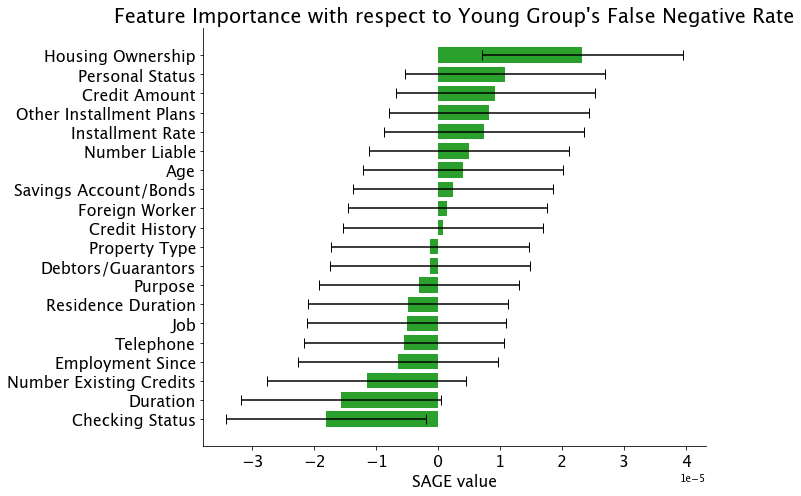

In [13]:
sage_values_young_fnr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Negative Rate')

# Old group FNR

In [14]:
where_old_train = train[:,age_col] > 30
where_old_test = np.invert(where_young_test)

test_old = test[where_old_test]
Y_test_old = Y_test[where_old_test]

In [15]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[where_old_train])
estimator_old_fnr = sage.PermutationEstimator(imputer_old, 'fnr')
%time sage_values_old_fnr = estimator_old_fnr(test_old, Y_test_old, verbose=True, thresh=0.2)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_old_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 411, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 411, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 411, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 411, fnr = 0.0024330900243309003
	Loss = 0.0024330900243309003 [inner loop]
fn = 1, p = 411, fnr = 0.0024330900243309003
	Loss = 0.0024330900243309003 [inner loop]
fn = 3, p = 411, fnr = 0.0072992700729927005
	Loss = 0.0072992700729927005 [inner loop]
fn = 5, p = 411, fnr = 0.012165450121654502
	Loss = 0.012165450121654502 [inner loop]
fn = 7, p = 411, fnr = 0.0170316301703163
	Loss = 0.0170316301703163 [inner loop]
fn = 7, p = 411, fnr = 0.0170316301703163
	Loss = 0.0170316301703163 [inner loop]
fn = 9, p = 411, fnr = 0.021897810218978103
	Loss = 0.021897810218978103 [inner loop]
fn = 9, p = 411, fnr = 0.021897810218978103
	Loss = 0.021897810218978103 [inner loop]
fn = 11, p = 411, fnr = 0.0267639902676399
	Loss = 0.0267639902676399 [inner loop]
fn = 9, p = 411, fnr = 0.021897810218978103
	Loss = 0

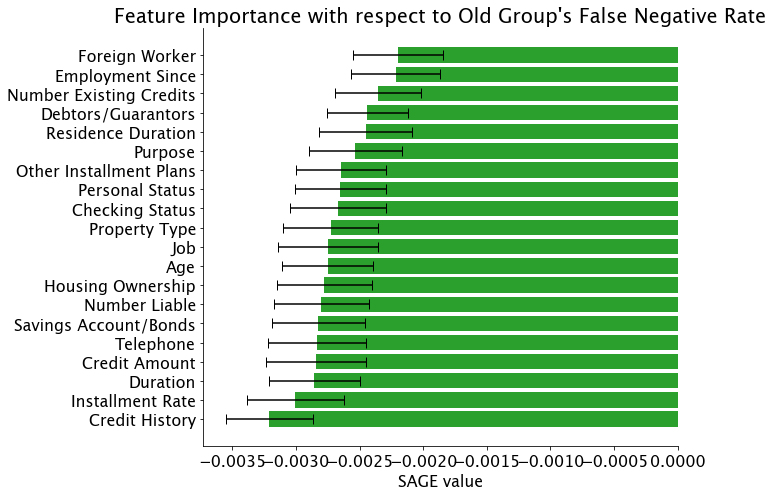

In [16]:
sage_values_old_fnr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Negative Rate')